In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from copy import deepcopy

In [2]:
seq_dim = (12,12)

In [3]:

def pbc(i,L=seq_dim[0]):
    assert i>=-1 and i<=L
    if i-L == 0:
        return 0
    elif i == -1:
        return L-1
    else:
        return i
    
from copy import deepcopy
def ising_boltzman_prob_nn(seq, J=1, kBT=1.0):
    shape = seq.shape
    # spins = seq.clone().detach()
    spins = deepcopy(seq)
    spins[np.where(spins==0)]=-1
    B,H,W = shape
    E = np.zeros(B)
    for i in range(H):
        for j in range(W):
            E += -spins[:,i,j]*spins[:,pbc(i-1),j]*J
            E += -spins[:,i,j]*spins[:,pbc(i+1),j]*J
            E += -spins[:,i,j]*spins[:,i,pbc(j-1)]*J
            E += -spins[:,i,j]*spins[:,i,pbc(j+1)]*J

    E /= 2
    prob = np.exp(-E/kBT)
    return E/kBT

def Ising_magnetization(seq):
    data = np.sum(seq.reshape([-1,np.prod(seq_dim)]), axis=-1)
    return data


def logits2seq(logits_t):
    seq_t = []
    for logits in logits_t:
        seq = np.argmax(logits, axis=-1)
        seq[np.where(seq==0)] = -1
        seq_t.append(seq.reshape(-1,*seq_dim))
    return seq_t

def histvar(seq, varfunc, bins):
    var = varfunc(seq)
    hist, bin_edges = np.histogram(var, bins=bins)
    bin_centers = np.array([(bin_edges[i]+bin_edges[i+1])/2. for i in range(len(bin_edges)-1)])
    P = hist/np.sum(hist)
    idxF = np.where(hist>0)
    F = -np.log(P[idxF])
    return hist, bin_centers, P, F, idxF



In [4]:

def run_loading(Tlist):
    magn = np.arange(-np.prod(seq_dim), np.prod(seq_dim)+1, 2)
    bins=np.linspace(magn[0]-1, magn[-1]+1, np.prod(seq_dim)+1+1)

    ### loading MC data and calculating the potential energy and its statistics
    s_time = time.time()
    seq_ref_list = {}
    for idx_jj, jj in enumerate(Tlist):
        print(">>> LOADING REF:: ",jj)
        seq_ref = np.load("/nfs/scistore14/chenggrp/ptuo/NeuralRG/data/ising-latt12x12-T4.0/latt12x12/buffer-S%.2f.npy"%(jj)).astype(np.float16).reshape(-1,*seq_dim)
        seq_ref_list[jj] = (seq_ref)
        e_time = time.time()
        print("Time for loading MC data:: ", e_time-s_time)
    return seq_ref_list

In [5]:
seq_T4 = run_loading([4.0])

>>> LOADING REF::  4.0
Time for loading MC data::  8.427311182022095


In [6]:
magn_T4 = Ising_magnetization(seq_T4[4.0])

In [7]:
pote_T4 = ising_boltzman_prob_nn(seq_T4[4.0])

In [8]:
seq_T = {}
seq_T[4.0] = seq_T4

In [9]:
seq_T[2.4] = run_loading([2.4])

>>> LOADING REF::  2.4
Time for loading MC data::  8.878659009933472


In [10]:
seq_T[2.0] = run_loading([2.0])

>>> LOADING REF::  2.0
Time for loading MC data::  6.15706729888916


In [11]:
magn_T = {}
magn_T[4.0] = magn_T4
pote_T = {}
pote_T[4.0] = pote_T4

In [12]:
magn_T[2.4] = Ising_magnetization(seq_T[2.4][2.4])

In [13]:
pote_T[2.4] = ising_boltzman_prob_nn(seq_T[2.4][2.4])

In [14]:
magn_T[2.0] = Ising_magnetization(seq_T[2.0][2.0])
pote_T[2.0] = ising_boltzman_prob_nn(seq_T[2.0][2.0])

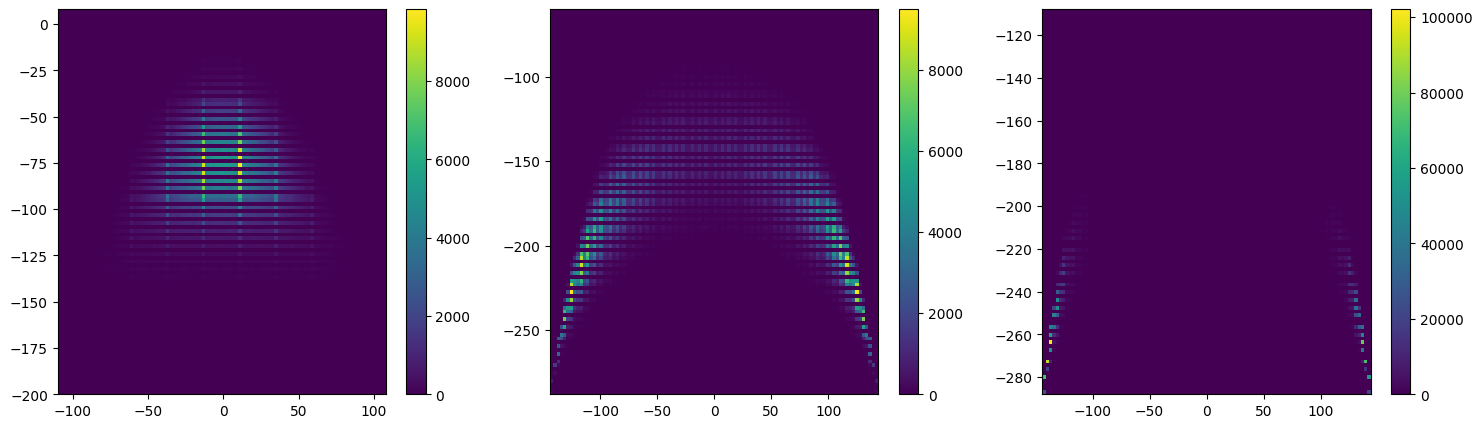

In [15]:
plt.figure(figsize=(18,5))
plt.subplot(131)
_ = plt.hist2d(magn_T[4.0], pote_T[4.0], bins=100)
plt.colorbar()
plt.subplot(132)
_ = plt.hist2d(magn_T[2.4], pote_T[2.4], bins=100)
plt.colorbar()
plt.subplot(133)
_ = plt.hist2d(magn_T[2.0], pote_T[2.0], bins=100)
plt.colorbar()

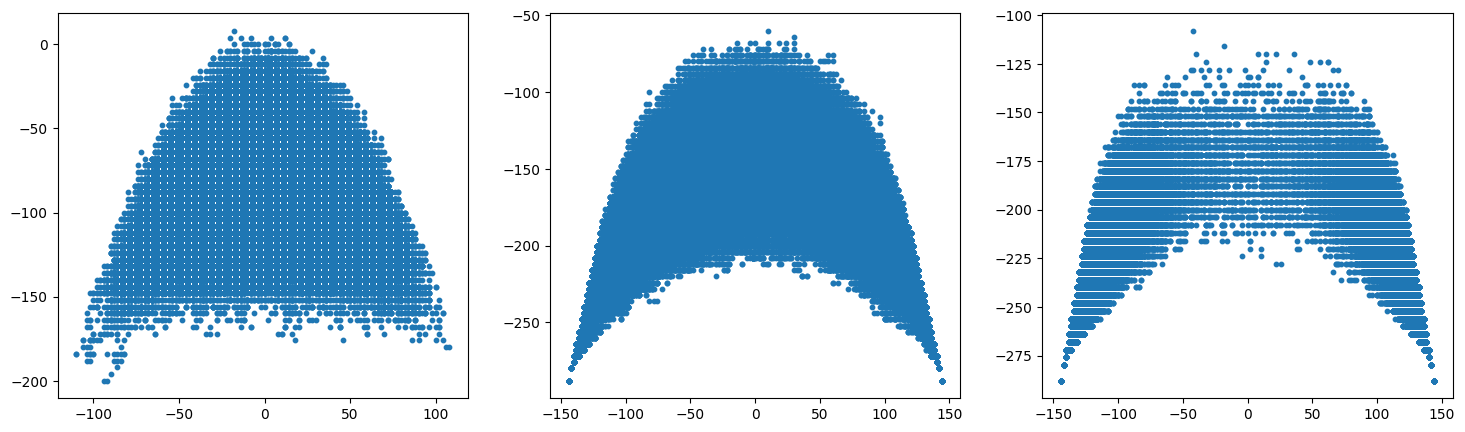

In [16]:
plt.figure(figsize=(18,5))
plt.subplot(131)
plt.scatter(magn_T[4.0], pote_T[4.0], s=10, label="$k_BT$=%f"%(4.0))

plt.subplot(132)
plt.scatter(magn_T[2.4], pote_T[2.4], s=10, label="$k_BT$=%f"%(2.4))

plt.subplot(133)
plt.scatter(magn_T[2.0], pote_T[2.0], s=10, label="$k_BT$=%f"%(2.0))



In [17]:
idx_e1={}
idx_e1[4.0] = np.where(pote_T[4.0] == -20)[0]
idx_e1[2.4] = np.where(pote_T[2.4] == -20)[0]
idx_e1[2.0] = np.where(pote_T[2.0] == -20)[0]

In [19]:
from collections import Counter
c_pote_T4 = Counter(pote_T[4.0])
print(sorted(list(c_pote_T4.keys())))

[-200.0, -196.0, -192.0, -188.0, -184.0, -180.0, -176.0, -172.0, -168.0, -164.0, -160.0, -156.0, -152.0, -148.0, -144.0, -140.0, -136.0, -132.0, -128.0, -124.0, -120.0, -116.0, -112.0, -108.0, -104.0, -100.0, -96.0, -92.0, -88.0, -84.0, -80.0, -76.0, -72.0, -68.0, -64.0, -60.0, -56.0, -52.0, -48.0, -44.0, -40.0, -36.0, -32.0, -28.0, -24.0, -20.0, -16.0, -12.0, -8.0, -4.0, 0.0, 4.0, 8.0]


In [21]:
idx_magn0_T4 = np.where(magn_T4==0)

In [22]:
seq_T4[4.0].shape, magn_T4.shape

((2000000, 12, 12), (2000000,))

([], [])

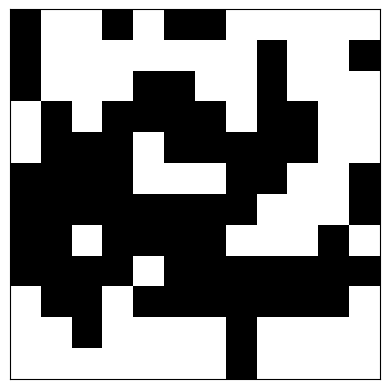

In [26]:
ridx = np.random.choice(idx_magn0_T4[0])
plt.imshow(seq_T4[4.0][ridx], cmap='Greys', vmin=-1, vmax=1)
plt.xticks([])
plt.yticks([])